### Quick experiment

Setting up quick Bayesian AB test based on: https://towardsdatascience.com/bayesian-a-b-testing-in-pymc3-54dceb87af74.

Other topic to explore:
- Test other distributions for sales/incremental sales (outside Bernoulli/Beta)
- How much sample is enough to avoid False Discovery / Peeking?
- Stress test `pymc3`

In [1]:
import os
import pymc3 as pm
import numpy as np
import pandas as pd

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sql = '''
    SELECT 
        crn, 
        model, 
        max(redeem_flag) AS rdm
    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
    WHERE 1=1
        AND offer_type = 'SS1'
        AND ref_dt = '2021-10-24'
    GROUP BY 1,2;
'''

df = bq.query(sql).result().to_dataframe()

In [3]:
m_conversion = df[df.model=='M'].rdm.values
r_conversion = df[df.model=='R'].rdm.values

In [4]:
with pm.Model():
    m_prior = pm.Beta('m_prior', 1, 99)
    r_prior = pm.Beta('r_prior', 1, 99)
    
    m_obs = pm.Bernoulli('m_obs', m_prior, observed=m_conversion)
    r_obs = pm.Bernoulli('r_obs', r_prior, observed=r_conversion)
    
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_prior, m_prior]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.


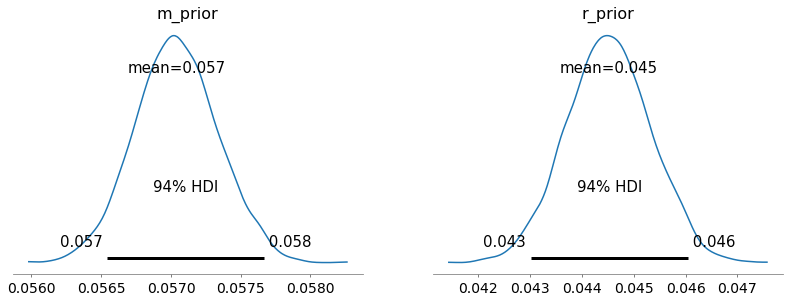

In [10]:
import arviz as az
fig = az.plot_posterior(trace)

In [8]:
m_samples = trace.posterior['m_prior'].values
r_samples = trace.posterior['r_prior'].values

print(f'Probability that model is better: {(m_samples > r_samples).mean():.1%}.')

Probability that model is better: 100.0%.
